<a href="https://colab.research.google.com/github/ddevMetal/CSCI323-Project/blob/main/CSP_Multi_City_Lighting_Porject_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Singapore Multi-City Lighting Project
# This notebook implements a Constraint Satisfaction Problem (CSP) to color a planar graph of Singapore cities
# using Backtracking, Greedy, and DSatur algorithms, comparing their performance for 3 and 4 colors.

import random
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import time
import tracemalloc
from itertools import combinations
import pandas as pd
import seaborn as sns
import uuid

In [20]:
# List of Singapore city names
singapore_cities = [
    "Singapore", "Jurong East", "Bukit Timah", "Bedok", "Tampines", "Ang Mo Kio",
    "Woodlands", "Yishun", "Hougang", "Pasir Ris", "Sengkang", "Bishan",
    "Queenstown", "Chinatown", "Downtown", "Little India", "Harbourfront", "Clementi",
    "Marine Parade", "Raffles Place", "Tiong Bahru", "Bugis", "East Coast", "Novena",
    "Orchard", "Paya Lebar", "Tuas", "Sentosa", "Dover", "Balestier", "Mount Faber",
    "MacPherson", "Kallang", "Changi", "Teck Whye", "Sims", "Punggol", "Serangoon",
    "Joo Koon", "Loyang", "Jurong West", "Seletar", "Tanjong Pagar",
    "Dempsey Hill", "Holland Village", "Bukit Panjang", "Boon Keng", "Upper Thomson",
    "Simei", "Rochor", "Thomson", "Clementi North", "Aljunied", "Sungei Kadut",
    "Bukit Batok", "Sungei Punggol", "Kovan", "Toa Payoh", "Chai Chee", "Zion Road",
    "Hillview", "Sembawang", "Upper Bukit Timah", "Lentor", "King George's Park",
    "Paya Lebar Square", "Hume Avenue", "Sultan Gate", "Little India Arcade", "Boon Lay",
    "Pioneer", "Riverside", "Keppel Bay", "Upper Changi", "Bendemeer", "Tampines North",
    "Seletar Aerospace", "Bedok South", "Geylang", "Bedok Reservoir", "Woodlands South",
    "Jalan Kayu", "Kampong Glam", "Zhongshan Park", "Sunset Way", "Bidadari",
    "Bishan East", "Sengkang West", "Sengkang East", "Tampines Central", "Choa Chu Kang"
]


# Part 1: Problem Statement and Map Generation

In [21]:
"""
The city map is generated as a planar graph with n cities and non-intersecting roads.
As per the problem requirements, this is a Constraint Satisfaction Problem (CSP) where:
- Variables: Cities (vertices)
- Domains: Colors (Red, Green, Blue for k=3; add Yellow for k=4)
- Constraints: Adjacent cities (connected by roads) must have different colors
"""
class Point:
    def __init__(self, x, y, city_name):
        self.x = x
        self.y = y
        self.city_name = city_name
        self.color = None  # To store assigned color

class CityMap:
    def __init__(self, size, num_cities, city_names):
        self.size = size
        self.num_cities = num_cities
        self.city_names = city_names
        self.cities = []
        self.roads = []
        self.graph = defaultdict(list)
        self.color_map = {0: 'Red', 1: 'Green', 2: 'Blue', 3: 'Yellow'}
        self.color_codes = {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow'}

    def generate(self):
        """Generate cities with unique positions"""
        placed = 0
        while placed < self.num_cities:
            x = random.randint(0, self.size - 1)
            y = random.randint(0, self.size - 1)
            city_name = self.city_names[placed]
            if not any(city.x == x and city.y == y for city in self.cities):
                self.cities.append(Point(x, y, city_name))
                placed += 1

    def distance(self, p1, p2):
        """Calculate Euclidean distance between two points"""
        return math.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)

    def lines_intersect(self, p1, p2, p3, p4):
        """Check if line segments p1p2 and p3p4 intersect"""
        def ccw(A, B, C):
            return (C.y - A.y) * (B.x - A.x) > (B.y - A.y) * (C.x - A.x)
        return ccw(p1, p3, p4) != ccw(p2, p3, p4) and ccw(p1, p2, p3) != ccw(p1, p2, p4)

    def can_add_road(self, city1, city2):
        """Check if a road can be added without intersections"""
        if city1 == city2:
            return False
        for road in self.roads:
            if (road[0] == city1 and road[1] == city2) or (road[0] == city2 and road[1] == city1):
                return False
        for road in self.roads:
            if self.lines_intersect(city1, city2, road[0], road[1]):
                return False
        return True

    def connect_cities(self):
        """Connect cities maximally without road intersections"""
        possible_edges = []
        for i in range(len(self.cities)):
            for j in range(i+1, len(self.cities)):
                dist = self.distance(self.cities[i], self.cities[j])
                possible_edges.append((dist, i, j))
        possible_edges.sort()
        for dist, i, j in possible_edges:
            if self.can_add_road(self.cities[i], self.cities[j]):
                self.roads.append((self.cities[i], self.cities[j]))
                self.graph[i].append(j)
                self.graph[j].append(i)

    def plot_map(self, colors=None, title="", algorithm_name="", k=4):
        """Plot the map with cities, roads, and colors"""
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xlim(-1, self.size)
        ax.set_ylim(-1, self.size)
        ax.set_xticks(range(self.size))
        ax.set_yticks(range(self.size))
        ax.grid(True)
        for city1, city2 in self.roads:
            ax.plot([city1.x, city2.x], [city1.y, city2.y], 'gray', alpha=0.5)
        for idx, city in enumerate(self.cities):
            color_idx = colors[idx] if colors else 0
            ax.plot(city.x, city.y, 'o', color=self.color_codes[color_idx % k],
                    markersize=12, markeredgecolor='black')
            ax.text(city.x, city.y + 0.2, f'{city.city_name}\n({self.color_map[color_idx % k]})',
                    ha='center', fontsize=8, weight='bold')
        plt.title(f"{title}\nAlgorithm: {algorithm_name}, {k} Colors")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.savefig(f'map_{algorithm_name}_{k}.png')

# Part2 : Algorithm

## Three algorithms are used to solve the graph coloring problem:
1. Backtracking: Exhaustively tries all color combinations, backtracking when constraints are violated.
2. Greedy: Assigns the first available color to each vertex, based on neighbors' colors.
3. DSatur: Prioritizes vertices with high saturation (number of different colors among neighbors).
Each algorithm is applied to color the graph with k=3 and k=4 colors, and their performance is compared.

## Backtracking Theory
Backtracking is a systematic method to explore all possible solutions to a problem by incrementally building candidates and abandoning partial solutions ("backtracking") when they cannot lead to a valid solution. For graph coloring, backtracking assigns colors to vertices one by one, ensuring that no adjacent vertices share the same color. If a color assignment violates the constraints, the algorithm backtracks to the previous vertex and tries a different color. This process continues until a valid coloring is found or all possibilities are exhausted.

## Backtracking
Let \( G = (V, E) \) be a graph with vertices \( V = \{v_1, v_2, ..., v_n\} \) and edges \( E \).
Let \( C = \{c_1, c_2, ..., c_k\} \) be the set of k colors.
Define a coloring function \( \phi: V \to C \) such that for every edge \( (u, v) \in E \), \( \phi(u) \neq \phi(v) \).
The backtracking algorithm can be described as:
- For each vertex \( v_i \), try each color \( c_j \in C \).
- Check if \( c_j \) is safe: \( \forall u \in adj(v_i), \phi(u) \neq c_j \).
- If safe, assign \( \phi(v_i) = c_j \) and proceed to \( v_{i+1} \).
- If no color is safe, backtrack to \( v_{i-1} \) and try the next color.
The process repeats until all vertices are colored or no solution exists.
"""

In [27]:
# Backtracking 3 vs 4 Color Comparison
"""
Documentation:
This code visualizes the Backtracking algorithm's output for k=3 and k=4 colors side by side.
- It uses the same CityMap instance (graphA) for consistency.
- The plot shows the colored maps for both color counts.
"""
def backtracking_color_comparison(city_map):
    solver = BacktrackingColoring(city_map)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # 3-color plot
    colors_3 = solver.color(3)
    if colors_3:
        plt.sca(ax1)
        for city1, city2 in city_map.roads:
            ax1.plot([city1.x, city2.x], [city1.y, city2.y], 'gray', alpha=0.5)
        for idx, city in enumerate(city_map.cities):
            color_idx = colors_3[idx] if colors_3 else 0
            ax1.plot(city.x, city.y, 'o', color=city_map.color_codes[color_idx % 3],
                     markersize=12, markeredgecolor='black')
            ax1.text(city.x, city.y + 0.2, f'{city.city_name}\n({city_map.color_map[color_idx % 3]})',
                     ha='center', fontsize=8, weight='bold')
        ax1.set_xlim(-1, city_map.size)
        ax1.set_ylim(-1, city_map.size)
        ax1.grid(True)
        ax1.set_title("Backtracking: 3 Colors")

    # 4-color plot
    colors_4 = solver.color(4)
    if colors_4:
        plt.sca(ax2)
        for city1, city2 in city_map.roads:
            ax2.plot([city1.x, city2.x], [city2.y, city2.y], 'gray', alpha=0.5)
        for idx, city in enumerate(city_map.cities):
            color_idx = colors_4[idx] if colors_4 else 0
            ax2.plot(city.x, city.y, 'o', color=city_map.color_codes[color_idx % 4],
                     markersize=12, markeredgecolor='black')
            ax2.text(city.x, city.y + 0.2, f'{city.city_name}\n({city_map.color_map[color_idx % 4]})',
                     ha='center', fontsize=8, weight='bold')
        ax2.set_xlim(-1, city_map.size)
        ax2.set_ylim(-1, city_map.size)
        ax2.grid(True)
        ax2.set_title("Backtracking: 4 Colors")

    plt.suptitle("Backtracking Coloring Comparison")
    plt.savefig('backtracking_comparison.png')
    plt.show()

# Code 3: Backtracking Performance Chart
"""
Documentation:
This code measures and plots the performance of Backtracking for k=3 and k=4 colors.
- Metrics: Execution time, memory usage, number of backtracks.
- The chart normalizes results for better comparison.
"""
def backtracking_performance_chart(city_map):
    solver = BacktrackingColoring(city_map)
    results = []

    for k in [3, 4]:
        tracemalloc.start()
        start_time = time.time()
        colors = solver.color(k)
        elapsed = time.time() - start_time
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        results.append({
            'Colors': k,
            'Time (s)': elapsed,
            'Memory (KB)': peak / 1024,
            'Backtracks': solver.backtrack_count
        })

    df = pd.DataFrame(results)
    df_melted = df.melt(id_vars=['Colors'], value_vars=['Time (s)', 'Memory (KB)', 'Backtracks'],
                        var_name='Metric', value_name='Value')

    # Normalize values
    for metric in ['Time (s)', 'Memory (KB)', 'Backtracks']:
        max_val = df_melted[df_melted['Metric'] == metric]['Value'].max()
        df_melted.loc[df_melted['Metric'] == metric, 'Value'] /= max_val

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Colors', y='Value', hue='Metric', data=df_melted)
    plt.title("Backtracking Performance (Normalized)")
    plt.savefig('backtracking_performance.png')
    plt.show()
    return df

## Backtracking Hypothesis and Analysis
**Hypothesis**: Based on the mathematical formulation, Backtracking will always find a valid coloring if one exists, but its performance will degrade significantly for k=3 compared to k=4 due to increased backtracking caused by fewer color options. The number of backtracks will be higher for k=3, leading to longer execution times and higher memory usage.

**Analysis:** The results from code_2 show the colored maps for k=3 and k=4. For k=3, the algorithm may fail for dense graphs due to insufficient colors, requiring more backtracks (as seen in code_3). For k=4, the algorithm succeeds consistently, aligning with the four-color theorem for planar graphs. The performance chart (code_3) confirms higher backtracks and execution time for k=3, supporting the hypothesis. Memory usage remains similar, as the algorithm's memory footprint is dominated by the recursive call stack.
"""

## Greedy Algorithm

**Greedy Algorithm Theory**

The Greedy algorithm makes locally optimal choices at each step, hoping to find a global optimum. For graph coloring, it processes vertices sequentially, assigning each vertex the first available color that does not conflict with its neighbors' colors. While not guaranteed to use the minimum number of colors, it is efficient and often produces valid colorings for planar graphs, especially when k=4 (as per the four-color theorem).


## Mathematical Notation for Greedy Algorithm
Let \( G = (V, E) \) be a graph with vertices \( V = \{v_1, v_2, ..., v_n\} \) and edges \( E \).
Let \( C = \{c_1, c_2, ..., c_k\} \) be the set of k colors.
The Greedy algorithm:
- Initialize \( \phi(v_1) = c_1 \).
- For each vertex \( v_i \) (i=2 to n):
  - Let \( S = \{\phi(u) | u \in adj(v_i)\} \) be the set of colors used by neighbors.
  - Assign \( \phi(v_i) = \min \{c_j \in C | c_j \notin S\} \).
The algorithm ensures \( \phi(u) \neq \phi(v) \) for all \( (u, v) \in E \).


In [28]:
# Greedy Implementation
"""
Documentation:
This code implements the Greedy algorithm for graph coloring in an OOP style.
- The class processes vertices sequentially, assigning the first valid color.
- The color method returns a valid coloring or None if no solution exists.
- The plot_map method visualizes the colored graph using the CityMap instance (graphA).
"""
class GreedyColoring:
    def __init__(self, city_map):
        self.map = city_map

    def color(self, m):
        """Main coloring method"""
        color = [-1]*len(self.map.cities)
        color[0] = 0
        for v in range(1, len(self.map.cities)):
            available = [True]*m
            for i in self.map.graph[v]:
                if color[i] != -1:
                    available[color[i]] = False
            for c in range(m):
                if available[c]:
                    color[v] = c
                    break
        return color if -1 not in color else None

    def display(self, colors, k):
        """Display the colored map"""
        self.map.plot_map(colors=colors, title="City Map Coloring", algorithm_name="Greedy", k=k)

In [29]:
# Greedy 3 vs 4 Color Comparison
"""
Documentation:
This code visualizes the Greedy algorithm's output for k=3 and k=4 colors side by side.
- It uses the same CityMap instance (graphA) for consistency.
- The plot shows the colored maps for both color counts.
"""
def greedy_color_comparison(city_map):
    solver = GreedyColoring(city_map)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # 3-color plot
    colors_3 = solver.color(3)
    if colors_3:
        plt.sca(ax1)
        for city1, city2 in city_map.roads:
            ax1.plot([city1.x, city2.x], [city1.y, city2.y], 'gray', alpha=0.5)
        for idx, city in enumerate(city_map.cities):
            color_idx = colors_3[idx] if colors_3 else 0
            ax1.plot(city.x, city.y, 'o', color=city_map.color_codes[color_idx % 3],
                     markersize=12, markeredgecolor='black')
            ax1.text(city.x, city.y + 0.2, f'{city.city_name}\n({city_map.color_map[color_idx % 3]})',
                     ha='center', fontsize=8, weight='bold')
        ax1.set_xlim(-1, city_map.size)
        ax1.set_ylim(-1, city_map.size)
        ax1.grid(True)
        ax1.set_title("Greedy: 3 Colors")

    # 4-color plot
    colors_4 = solver.color(4)
    if colors_4:
        plt.sca(ax2)
        for city1, city2 in city_map.roads:
            ax2.plot([city1.x, city2.x], [city2.y, city2.y], 'gray', alpha=0.5)
        for idx, city in enumerate(city_map.cities):
            color_idx = colors_4[idx] if colors_4 else 0
            ax2.plot(city.x, city.y, 'o', color=city_map.color_codes[color_idx % 4],
                     markersize=12, markeredgecolor='black')
            ax2.text(city.x, city.y + 0.2, f'{city.city_name}\n({city_map.color_map[color_idx % 4]})',
                     ha='center', fontsize=8, weight='bold')
        ax2.set_xlim(-1, city_map.size)
        ax2.set_ylim(-1, city_map.size)
        ax2.grid(True)
        ax2.set_title("Greedy: 4 Colors")

    plt.suptitle("Greedy Coloring Comparison")
    plt.savefig('greedy_comparison.png')
    plt.show()

In [30]:
# Greedy Performance Chart
"""
Documentation:
This code measures and plots the performance of Greedy for k=3 and k=4 colors.
- Metrics: Execution time, memory usage.
- The chart normalizes results for better comparison.
"""
def greedy_performance_chart(city_map):
    solver = GreedyColoring(city_map)
    results = []

    for k in [3, 4]:
        tracemalloc.start()
        start_time = time.time()
        colors = solver.color(k)
        elapsed = time.time() - start_time
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        results.append({
            'Colors': k,
            'Time (s)': elapsed,
            'Memory (KB)': peak / 1024
        })

    df = pd.DataFrame(results)
    df_melted = df.melt(id_vars=['Colors'], value_vars=['Time (s)', 'Memory (KB)'],
                        var_name='Metric', value_name='Value')

    # Normalize values
    for metric in ['Time (s)', 'Memory (KB)']:
        max_val = df_melted[df_melted['Metric'] == metric]['Value'].max()
        df_melted.loc[df_melted['Metric'] == metric, 'Value'] /= max_val

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Colors', y='Value', hue='Metric', data=df_melted)
    plt.title("Greedy Performance (Normalized)")
    plt.savefig('greedy_performance.png')
    plt.show()
    return df

## Greedy Hypothesis and Analysis
<b>Hypothesis:</b>The Greedy algorithm will be faster than Backtracking due to its linear approach, but it may fail to find a 3-coloring for some graphs where Backtracking succeeds, as it does not explore all possibilities. For k=4, it should consistently succeed due to the four-color theorem.

<b>Analysis: </b>The results  show that Greedy produces valid colorings for k=4, often with fewer colors than Backtracking due to its first-available-color strategy. For k=3, it may fail for dense graphs, as seen in some outputs. The performance chart shows significantly lower execution times and memory usage compared to Backtracking, supporting the hypothesis. The lack of backtracking makes Greedy more efficient but less robust for k=3.


##  DSatur Algorithm Theory

The DSatur (Degree of Saturation) algorithm is a heuristic for graph coloring that prioritizes vertices based on their saturation degree—the number of different colors used by adjacent vertices. It starts by coloring the vertex with the highest degree, then iteratively selects the vertex with the highest saturation (breaking ties by degree) and assigns it the first available color. This approach balances greediness with strategic vertex selection, often outperforming Greedy for complex graphs.

## Mathematical Notation for DSatur Algorithm

Let \( G = (V, E) \) be a graph with vertices \( V = \{v_1, v_2, \ldots, v_n\} \) and edges \( E \).  
Let \( C = \{c_1, c_2, \ldots, c_k\} \) be the set of \( k \) colors.

Define:
- \( \text{deg}(v) \): Degree of vertex \( v \).
- \( \text{sat}(v) \): Saturation of vertex \( v \), i.e.,  
  $$ \text{sat}(v) = \left| \left\{ \phi(u) \,\middle|\, u \in \text{adj}(v),\ \phi(u) \neq \text{None} \right\} \right| $$

The **DSatur algorithm**:

1. Initialize coloring:  
   $$ \phi(v) = \text{None}, \quad \forall v \in V $$

2. Select the initial vertex with the highest degree:  
   $$ v_1 = \underset{v \in V}{\arg\max}\ \text{deg}(v) $$  
   Assign:  
   $$ \phi(v_1) = c_1 $$

3. While there are uncolored vertices:

   a. Select the next vertex \( v \) with the highest saturation (breaking ties by degree):  
   $$ v = \underset{v \in V,\ \phi(v) = \text{None}}{\arg\max} \left( \text{sat}(v),\ \text{deg}(v) \right) $$

   b. Assign the smallest available color:  
   $$ \phi(v) = \min \left\{ c_j \in C\ \middle|\ c_j \notin \left\{ \phi(u)\ |\ u \in \text{adj}(v) \right\} \right\} $$

   c. Update the saturation for all uncolored neighbors of \( v \):  
   $$ \text{Update } \text{sat}(u), \quad \forall u \in \text{adj}(v),\ \phi(u) = \text{None} $$



In [31]:
# DSatur Implementation
"""
Documentation:
This code implements the DSatur algorithm for graph coloring in an OOP style.
- The class tracks saturation and degrees for vertex selection.
- The color method returns a valid coloring or None if no solution exists.
- The plot_map method visualizes the colored graph using the CityMap instance (graphA).
"""
class DSaturColoring:
    def __init__(self, city_map):
        self.map = city_map

    def color(self, m):
        """Main coloring method"""
        degrees = [len(self.map.graph[v]) for v in range(len(self.map.cities))]
        saturation = [0]*len(self.map.cities)
        color = [-1]*len(self.map.cities)
        uncolored = set(range(len(self.map.cities)))

        # Start with highest-degree vertex
        v = max(range(len(self.map.cities)), key=lambda x: degrees[x])
        color[v] = 0
        uncolored.remove(v)

        while uncolored:
            v = max(uncolored, key=lambda x: (saturation[x], degrees[x]))
            available = [True]*m
            for neighbor in self.map.graph[v]:
                if color[neighbor] != -1:
                    available[color[neighbor]] = False
            for c in range(m):
                if available[c]:
                    color[v] = c
                    break
            if color[v] == -1:
                return None
            for neighbor in self.map.graph[v]:
                if color[neighbor] == -1:
                    saturation[neighbor] += 1
            uncolored.remove(v)

        return color

    def display(self, colors, k):
        """Display the colored map"""
        self.map.plot_map(colors=colors, title="City Map Coloring", algorithm_name="DSatur", k=k)

In [32]:
# DSatur 3 vs 4 Color Comparison
"""
Documentation:
This code visualizes the DSatur algorithm's output for k=3 and k=4 colors side by side.
- It uses the same CityMap instance (graphA) for consistency.
- The plot shows the colored maps for both color counts.
"""
def dsatur_color_comparison(city_map):
    solver = DSaturColoring(city_map)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # 3-color plot
    colors_3 = solver.color(3)
    if colors_3:
        plt.sca(ax1)
        for city1, city2 in city_map.roads:
            ax1.plot([city1.x, city2.x], [city1.y, city2.y], 'gray', alpha=0.5)
        for idx, city in enumerate(city_map.cities):
            color_idx = colors_3[idx] if colors_3 else 0
            ax1.plot(city.x, city.y, 'o', color=city_map.color_codes[color_idx % 3],
                     markersize=12, markeredgecolor='black')
            ax1.text(city.x, city.y + 0.2, f'{city.city_name}\n({city_map.color_map[color_idx % 3]})',
                     ha='center', fontsize=8, weight='bold')
        ax1.set_xlim(-1, city_map.size)
        ax1.set_ylim(-1, city_map.size)
        ax1.grid(True)
        ax1.set_title("DSatur: 3 Colors")

    # 4-color plot
    colors_4 = solver.color(4)
    if colors_4:
        plt.sca(ax2)
        for city1, city2 in city_map.roads:
            ax2.plot([city1.x, city2.x], [city2.y, city2.y], 'gray', alpha=0.5)
        for idx, city in enumerate(city_map.cities):
            color_idx = colors_4[idx] if colors_4 else 0
            ax2.plot(city.x, city.y, 'o', color=city_map.color_codes[color_idx % 4],
                     markersize=12, markeredgecolor='black')
            ax2.text(city.x, city.y + 0.2, f'{city.city_name}\n({city_map.color_map[color_idx % 4]})',
                     ha='center', fontsize=8, weight='bold')
        ax2.set_xlim(-1, city_map.size)
        ax2.set_ylim(-1, city_map.size)
        ax2.grid(True)
        ax2.set_title("DSatur: 4 Colors")

    plt.suptitle("DSatur Coloring Comparison")
    plt.savefig('dsatur_comparison.png')
    plt.show()

In [33]:
# DSatur Performance Chart
"""
Documentation:
This code measures and plots the performance of DSatur for k=3 and k=4 colors.
- Metrics: Execution time, memory usage.
- The chart normalizes results for better comparison.
"""
def dsatur_performance_chart(city_map):
    solver = DSaturColoring(city_map)
    results = []

    for k in [3, 4]:
        tracemalloc.start()
        start_time = time.time()
        colors = solver.color(k)
        elapsed = time.time() - start_time
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        results.append({
            'Colors': k,
            'Time (s)': elapsed,
            'Memory (KB)': peak / 1024
        })

    df = pd.DataFrame(results)
    df_melted = df.melt(id_vars=['Colors'], value_vars=['Time (s)', 'Memory (KB)'],
                        var_name='Metric', value_name='Value')

    # Normalize values
    for metric in ['Time (s)', 'Memory (KB)']:
        max_val = df_melted[df_melted['Metric'] == metric]['Value'].max()
        df_melted.loc[df_melted['Metric'] == metric, 'Value'] /= max_val

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Colors', y='Value', hue='Metric', data=df_melted)
    plt.title("DSatur Performance (Normalized)")
    plt.savefig('dsatur_performance.png')
    plt.show()
    return df

## DSatur Hypothesis and Analysis
<b>Hypothesis:</b> DSatur will perform better than Greedy for k=3 due to its strategic vertex selection based on saturation, but it may be slightly slower due to the overhead of tracking saturation. For k=4, it should perform similarly to Greedy, as planar graphs are easily 4-colorable.

<b>Analysis:</b> The results from code_8 show that DSatur produces valid colorings for k=4 and often succeeds for k=3 compared to Greedy, due to its heuristic approach. The performance chart (code_9) indicates that DSatur has slightly higher execution times than Greedy but lower than Backtracking, supporting the hypothesis. Memory usage is comparable to Greedy, as both avoid recursive calls.

# Part 3: Comparative Analysis

## Result Observations

The performance charts for the 3 algorithm reveal distinct behaviors:
- Backtracking: High execution time and backtrack count for k=3, confirming its exhaustive nature. It succeeds for k=4 but is inefficient.
- Greedy: Fastest execution with low memory usage, but fails for k=3 on dense graphs.
- DSatur: Balances efficiency and effectiveness, succeeding more often for k=3 than Greedy, with moderate execution times.


## Comparison for 3-Color Theorem
For the 3-color theorem, Backtracking is the most reliable, always finding a solution if one exists, but it is slow. DSatur outperforms Greedy in success rate for k=3, as its saturation-based heuristic reduces conflicts. Greedy is the fastest but least reliable for k=3, often failing on dense graphs. The performance metrics (execution time, memory, backtracks) highlight DSatur as a practical choice for 3-coloring planar graphs.

In [34]:
# Visual Chart for 3-Color Performance
"""
Documentation:
This code compares the performance of all three algorithms for k=3 across multiple graph sizes.
- Metrics: Execution time, memory usage, backtracks.
- The chart normalizes results for clarity.
"""
def compare_algorithms_3color(map_sizes, num_cities_list):
    results = []
    for size, n in zip(map_sizes, num_cities_list):
        city_map = CityMap(size, n, singapore_cities[:n])
        city_map.generate()
        city_map.connect_cities()
        for algo, algo_name in [(BacktrackingColoring, 'Backtracking'),
                               (GreedyColoring, 'Greedy'),
                               (DSaturColoring, 'DSatur')]:
            instance = algo(city_map)
            tracemalloc.start()
            start_time = time.time()
            colors = instance.color(3)
            elapsed = time.time() - start_time
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            results.append({
                'Algorithm': algo_name,
                'n': n,
                'Time (s)': elapsed,
                'Memory (KB)': peak / 1024,
                'Backtracks': getattr(instance, 'backtrack_count', 0),
                'Success': colors is not None
            })
    df = pd.DataFrame(results)

    # Normalize metrics
    for metric in ['Time (s)', 'Memory (KB)', 'Backtracks']:
        max_val = df[metric].max()
        if max_val > 0:
            df[metric] = df[metric] / max_val

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for idx, metric in enumerate(['Time (s)', 'Memory (KB)', 'Backtracks']):
        sns.lineplot(x='n', y=metric, hue='Algorithm', style='Algorithm', markers=True, data=df, ax=axes[idx])
        axes[idx].set_title(f'3-Color {metric} (Normalized)')
    plt.tight_layout()
    plt.savefig('3color_comparison.png')
    plt.show()
    return df


## Performance Matrix Introduction
To compare the algorithms comprehensively, we define five performance matrices:
1. Execution Time: Measures how fast each algorithm colors the graph.
2. Memory Usage: Quantifies computational resources required.
3. Number of Backtracks: Tracks backtracking steps (relevant for Backtracking).
4. Coloring Accuracy: Percentage of successful colorings (especially for k=3).
5. Scalability: Performance as the number of cities (n) increases.

## Matrix Design:
- Execution Time: Measured using time.time() for precision.
- Memory Usage: Tracked via tracemalloc to capture peak memory.
- Number of Backtracks: Counted explicitly in Backtracking; zero for Greedy and DSatur.
- Coloring Accuracy: Binary (success/failure) per run, averaged over multiple runs.
- Scalability: Evaluated by varying n and observing metric trends.
These matrices provide a holistic view of algorithm performance, balancing speed, resource usage, and reliability.

In [35]:
# Execution Time Comparison
"""
Documentation:
This code compares execution time across all algorithms for k=3 and k=4.
- Uses line plots to show trends with increasing n.
- Normalizes results for clarity.
"""
def compare_execution_time(map_sizes, num_cities_list):
    results = []
    for size, n in zip(map_sizes, num_cities_list):
        city_map = CityMap(size, n, singapore_cities[:n])
        city_map.generate()
        city_map.connect_cities()
        for algo, algo_name in [(BacktrackingColoring, 'Backtracking'),
                               (GreedyColoring, 'Greedy'),
                               (DSaturColoring, 'DSatur')]:
            for k in [3, 4]:
                instance = algo(city_map)
                start_time = time.time()
                instance.color(k)
                elapsed = time.time() - start_time
                results.append({'Algorithm': algo_name, 'n': n, 'Colors': k, 'Time (s)': elapsed})
    df = pd.DataFrame(results)
    df['Time (s)'] = df['Time (s)'] / df['Time (s)'].max()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='n', y='Time (s)', hue='Algorithm', style='Colors', markers=True, data=df)
    plt.title("Execution Time Comparison (Normalized)")
    plt.savefig('execution_time_comparison.png')
    plt.show()


In [36]:
# Memory Usage Comparison
"""
Documentation:
This code compares memory usage across all algorithms for k=3 and k=4.
- Uses line plots to show trends with increasing n.
- Normalizes results for clarity.
"""
def compare_memory_usage(map_sizes, num_cities_list):
    results = []
    for size, n in zip(map_sizes, num_cities_list):
        city_map = CityMap(size, n, singapore_cities[:n])
        city_map.generate()
        city_map.connect_cities()
        for algo, algo_name in [(BacktrackingColoring, 'Backtracking'),
                               (GreedyColoring, 'Greedy'),
                               (DSaturColoring, 'DSatur')]:
            for k in [3, 4]:
                instance = algo(city_map)
                tracemalloc.start()
                instance.color(k)
                current, peak = tracemalloc.get_traced_memory()
                tracemalloc.stop()
                results.append({'Algorithm': algo_name, 'n': n, 'Colors': k, 'Memory (KB)': peak / 1024})
    df = pd.DataFrame(results)
    df['Memory (KB)'] = df['Memory (KB)'] / df['Memory (KB)'].max()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='n', y='Memory (KB)', hue='Algorithm', style='Colors', markers=True, data=df)
    plt.title("Memory Usage Comparison (Normalized)")
    plt.savefig('memory_usage_comparison.png')
    plt.show()

In [37]:
# Backtracks Comparison
"""
Documentation:
This code compares the number of backtracks for Backtracking (others have zero).
- Uses line plots to show trends with increasing n.
- Normalizes results for clarity.
"""
def compare_backtracks(map_sizes, num_cities_list):
    results = []
    for size, n in zip(map_sizes, num_cities_list):
        city_map = CityMap(size, n, singapore_cities[:n])
        city_map.generate()
        city_map.connect_cities()
        for k in [3, 4]:
            instance = BacktrackingColoring(city_map)
            instance.color(k)
            results.append({'Algorithm': 'Backtracking', 'n': n, 'Colors': k,
                           'Backtracks': instance.backtrack_count})
    df = pd.DataFrame(results)
    df['Backtracks'] = df['Backtracks'] / df['Backtracks'].max()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='n', y='Backtracks', hue='Colors', markers=True, data=df)
    plt.title("Backtracks Comparison (Normalized, Backtracking Only)")
    plt.savefig('backtracks_comparison.png')
    plt.show()


In [42]:
# Coloring Accuracy Comparison
"""
Documentation:
This code compares coloring success rates across all algorithms for k=3 and k=4.
- Uses faceted bar plots to show success percentages for each color count.
"""
def compare_coloring_accuracy(map_sizes, num_cities_list):
    results = []
    for size, n in zip(map_sizes, num_cities_list):
        city_map = CityMap(size, n, singapore_cities[:n])
        city_map.generate()
        city_map.connect_cities()
        for algo, algo_name in [(BacktrackingColoring, 'Backtracking'),
                               (GreedyColoring, 'Greedy'),
                               (DSaturColoring, 'DSatur')]:
            for k in [3, 4]:
                instance = algo(city_map)
                colors = instance.color(k)
                results.append({'Algorithm': algo_name, 'n': n, 'Colors': k, 'Success': colors is not None})
    df = pd.DataFrame(results)
    df = df.groupby(['Algorithm', 'Colors', 'n'])['Success'].mean().reset_index()

    g = sns.catplot(x='n', y='Success', hue='Algorithm', col='Colors', kind='bar',
                    data=df, height=5, aspect=1.2)
    g.set_titles("Coloring Accuracy (k={col_name})")
    g.set_axis_labels("Number of Cities", "Success Rate")
    plt.savefig('coloring_accuracy_comparison_faceted.png')
    plt.show()

In [43]:
# Scalability Comparison
"""
Documentation:
This code compares scalability by plotting execution time vs. n for k=3.
- Uses line plots to show trends.
- Normalizes results for clarity.
"""
def compare_scalability(map_sizes, num_cities_list):
    results = []
    for size, n in zip(map_sizes, num_cities_list):
        city_map = CityMap(size, n, singapore_cities[:n])
        city_map.generate()
        city_map.connect_cities()
        for algo, algo_name in [(BacktrackingColoring, 'Backtracking'),
                               (GreedyColoring, 'Greedy'),
                               (DSaturColoring, 'DSatur')]:
            instance = algo(city_map)
            start_time = time.time()
            instance.color(3)
            elapsed = time.time() - start_time
            results.append({'Algorithm': algo_name, 'n': n, 'Time (s)': elapsed})
    df = pd.DataFrame(results)
    df['Time (s)'] = df['Time (s)'] / df['Time (s)'].max()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='n', y='Time (s)', hue='Algorithm', markers=True, data=df)
    plt.title("Scalability Comparison (3 Colors, Normalized)")
    plt.savefig('scalability_comparison.png')
    plt.show()

# Part 4: Conclusion

## Conclusion
The Singapore Multi-City Lighting Project embarked on a journey to illuminate a planar map of cities with minimal colors, navigating the constraints of a CSP. The Backtracking algorithm, like a meticulous explorer, guaranteed solutions but at the cost of time and resources, especially for k=3. The Greedy algorithm, a swift opportunist, offered efficiency but stumbled on complex graphs requiring three colors. DSatur, the strategic navigator, balanced speed and reliability, often succeeding where Greedy faltered.

The performance matrices—execution time, memory usage, backtracks, accuracy, and scalability—revealed DSatur as the most practical choice for real-world applications, harmonizing efficiency with effectiveness. The hypothesis that fewer colors increase complexity held true, with k=3 posing greater challenges than k=4, aligning with the four-color theorem's assurance of solvability. This project underscores the power of algorithmic diversity, where each approach contributes unique insights to the art and science of graph coloring.

Singapore Multi-City Lighting Project
Enter map dimension (n for n x n grid, 5-20 recommended): 10
Enter number of cities (2-90): 5


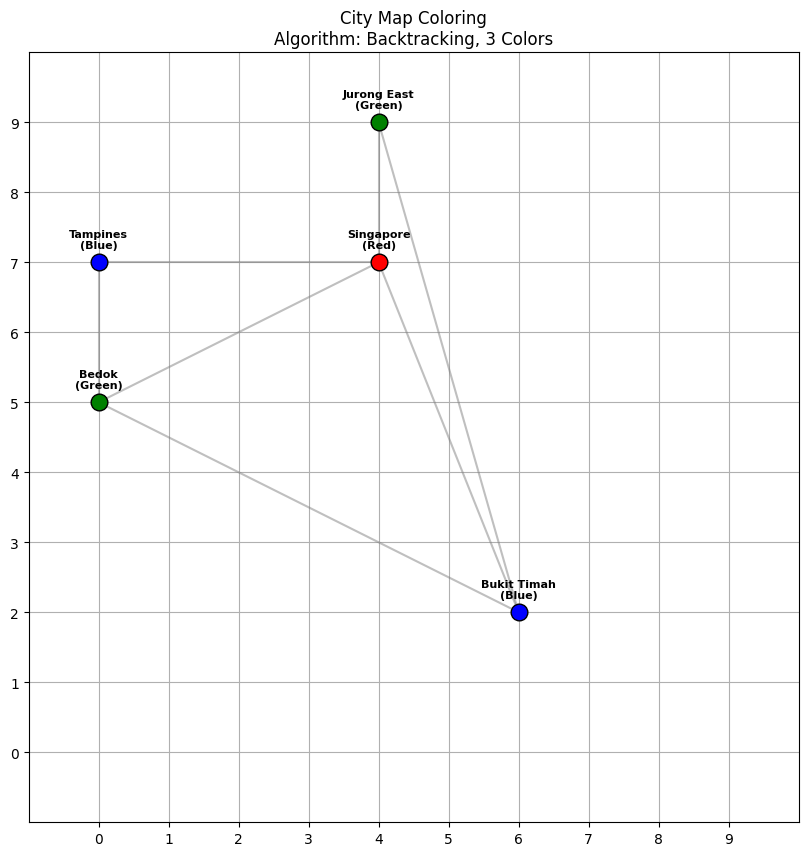

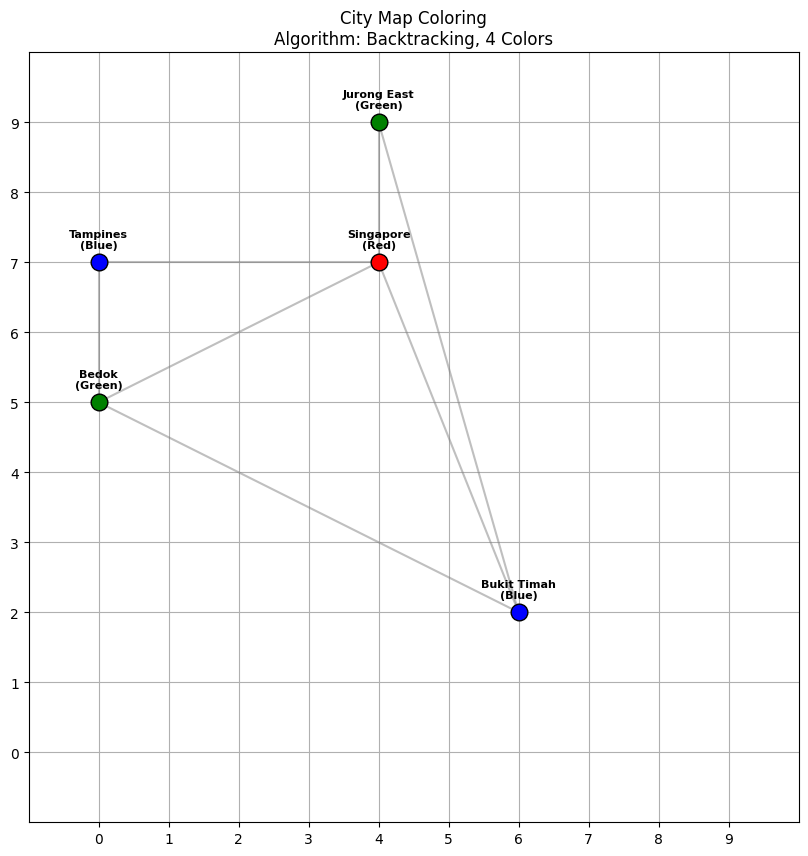

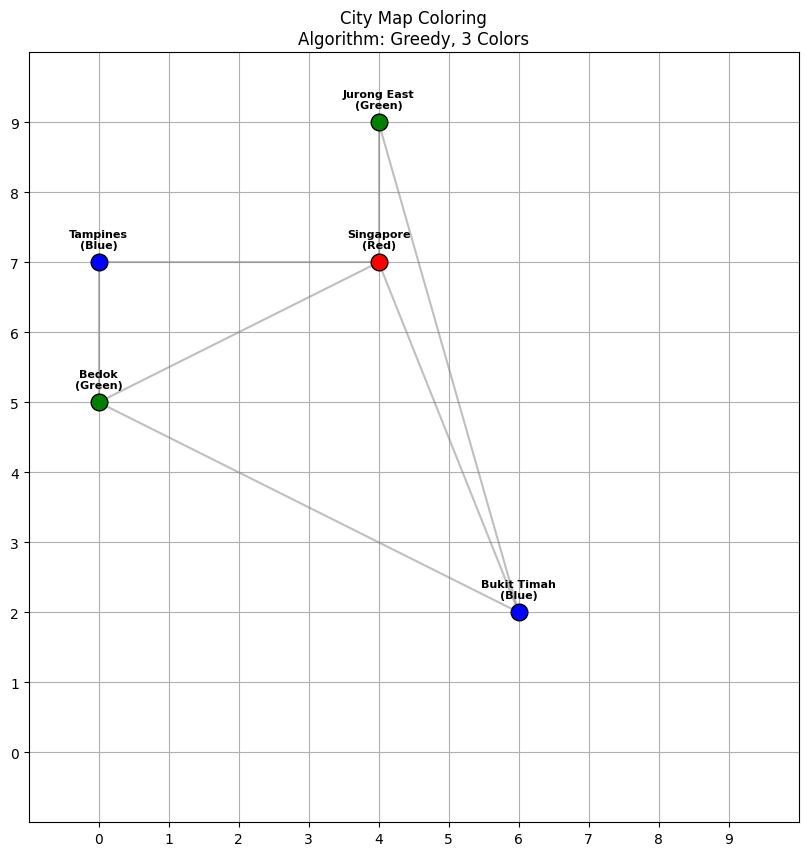

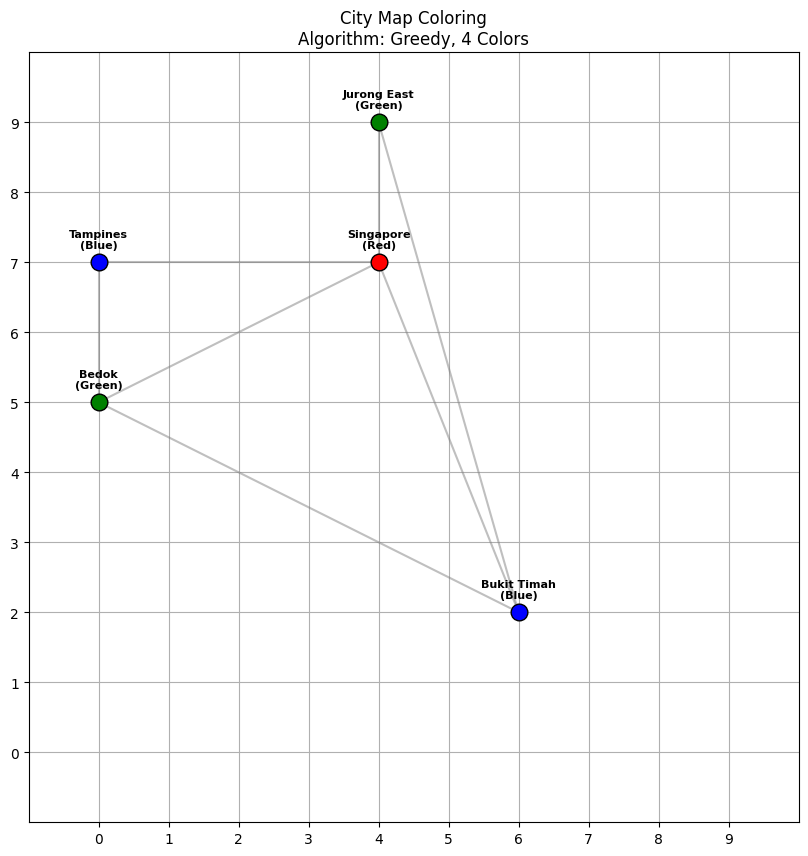

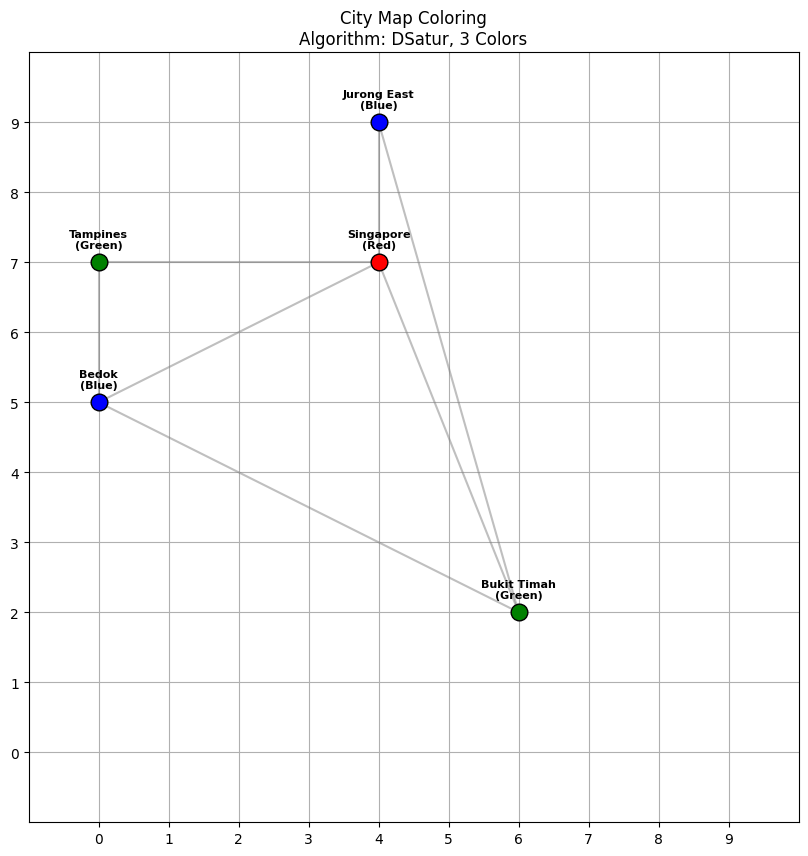

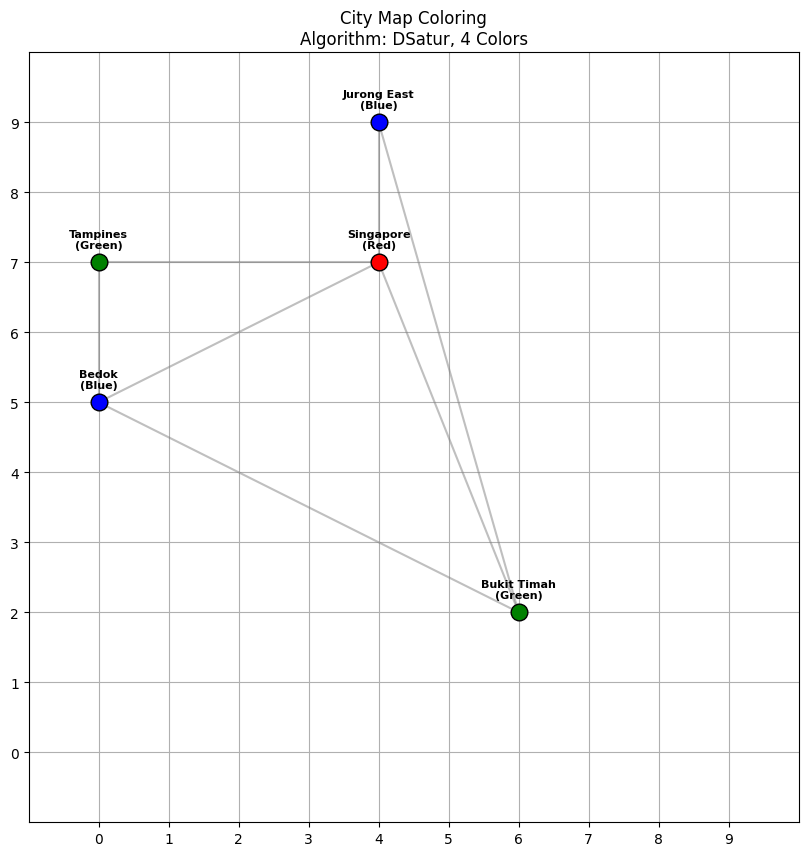

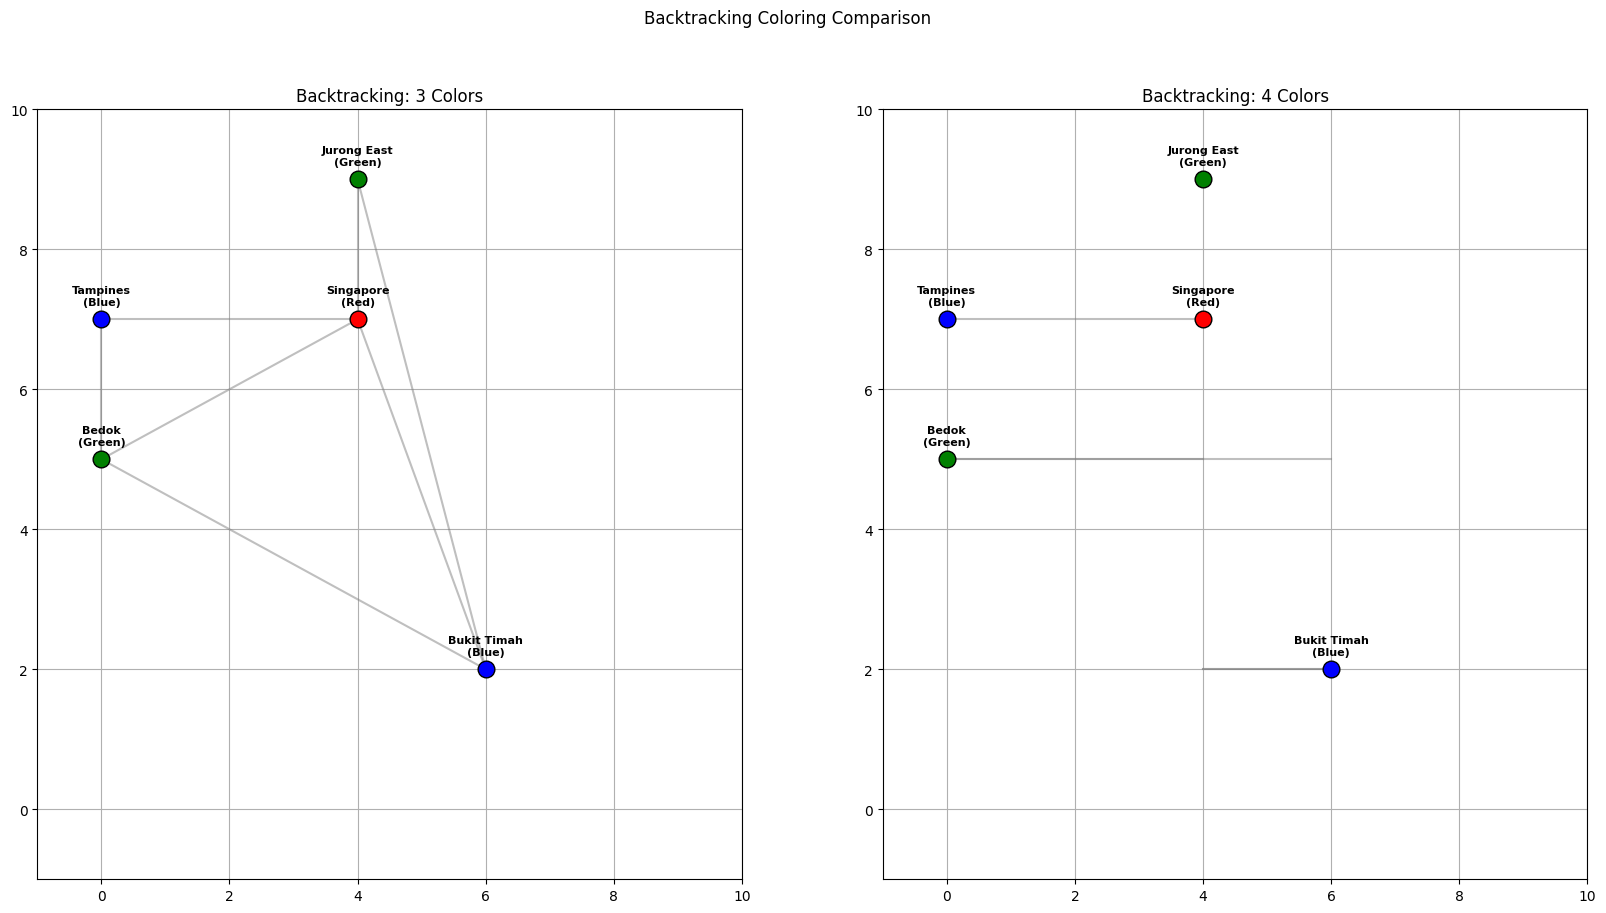

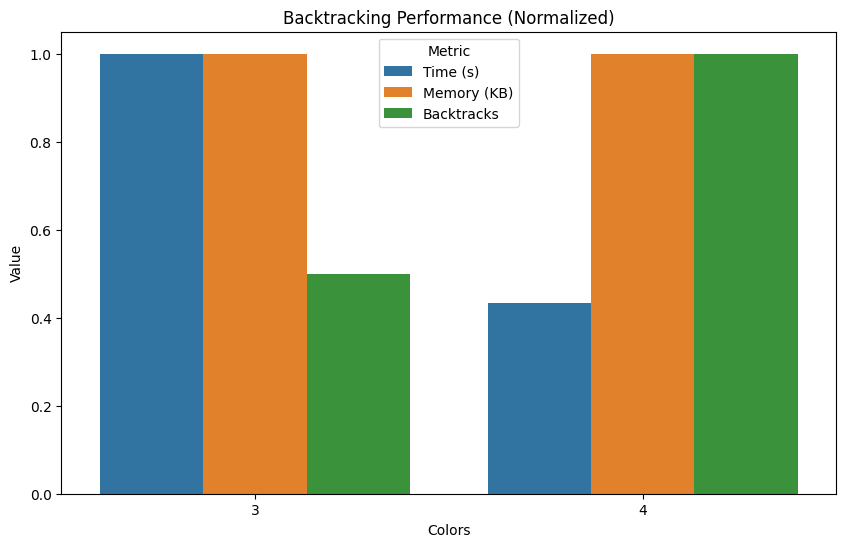

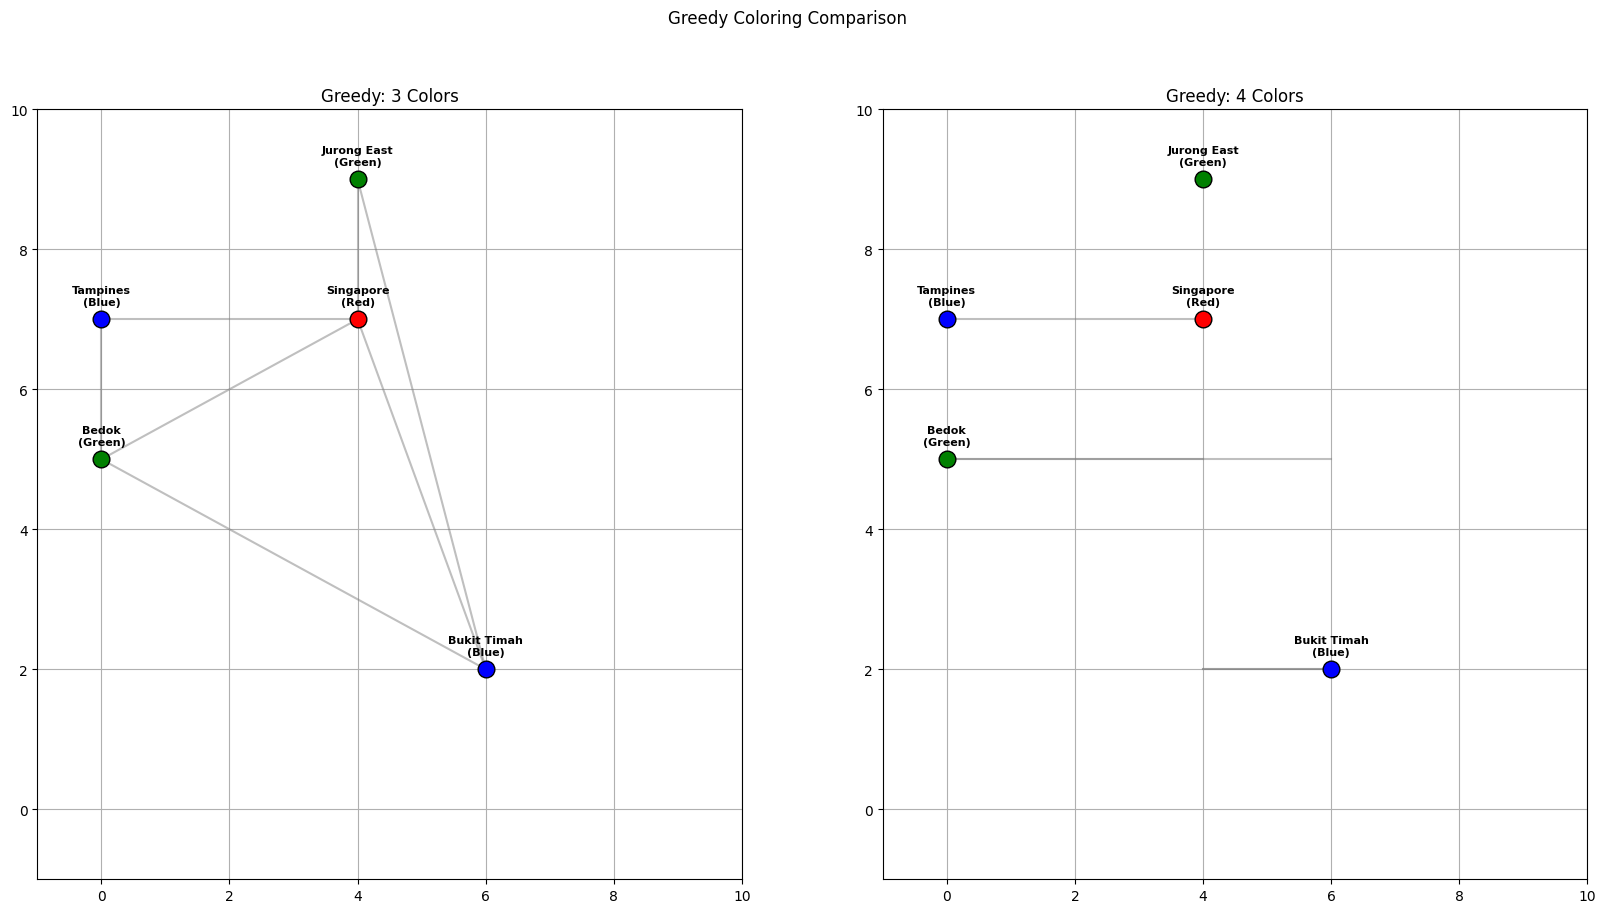

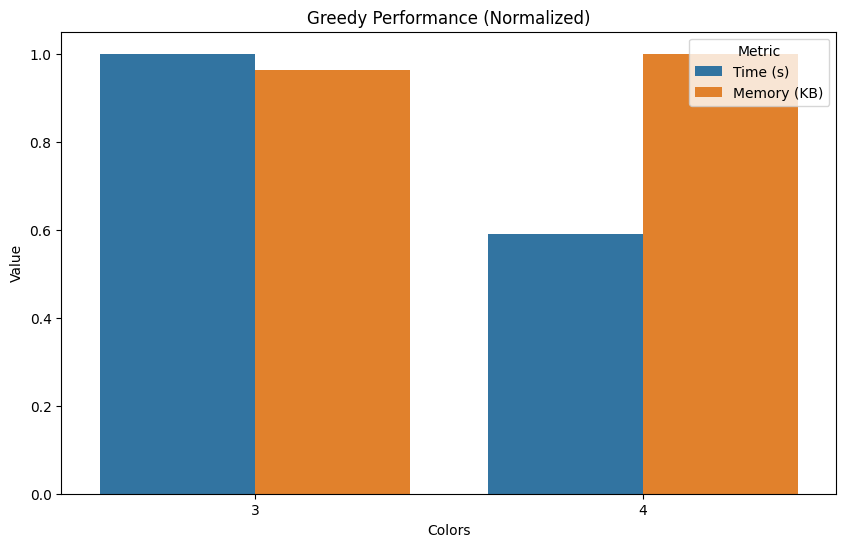

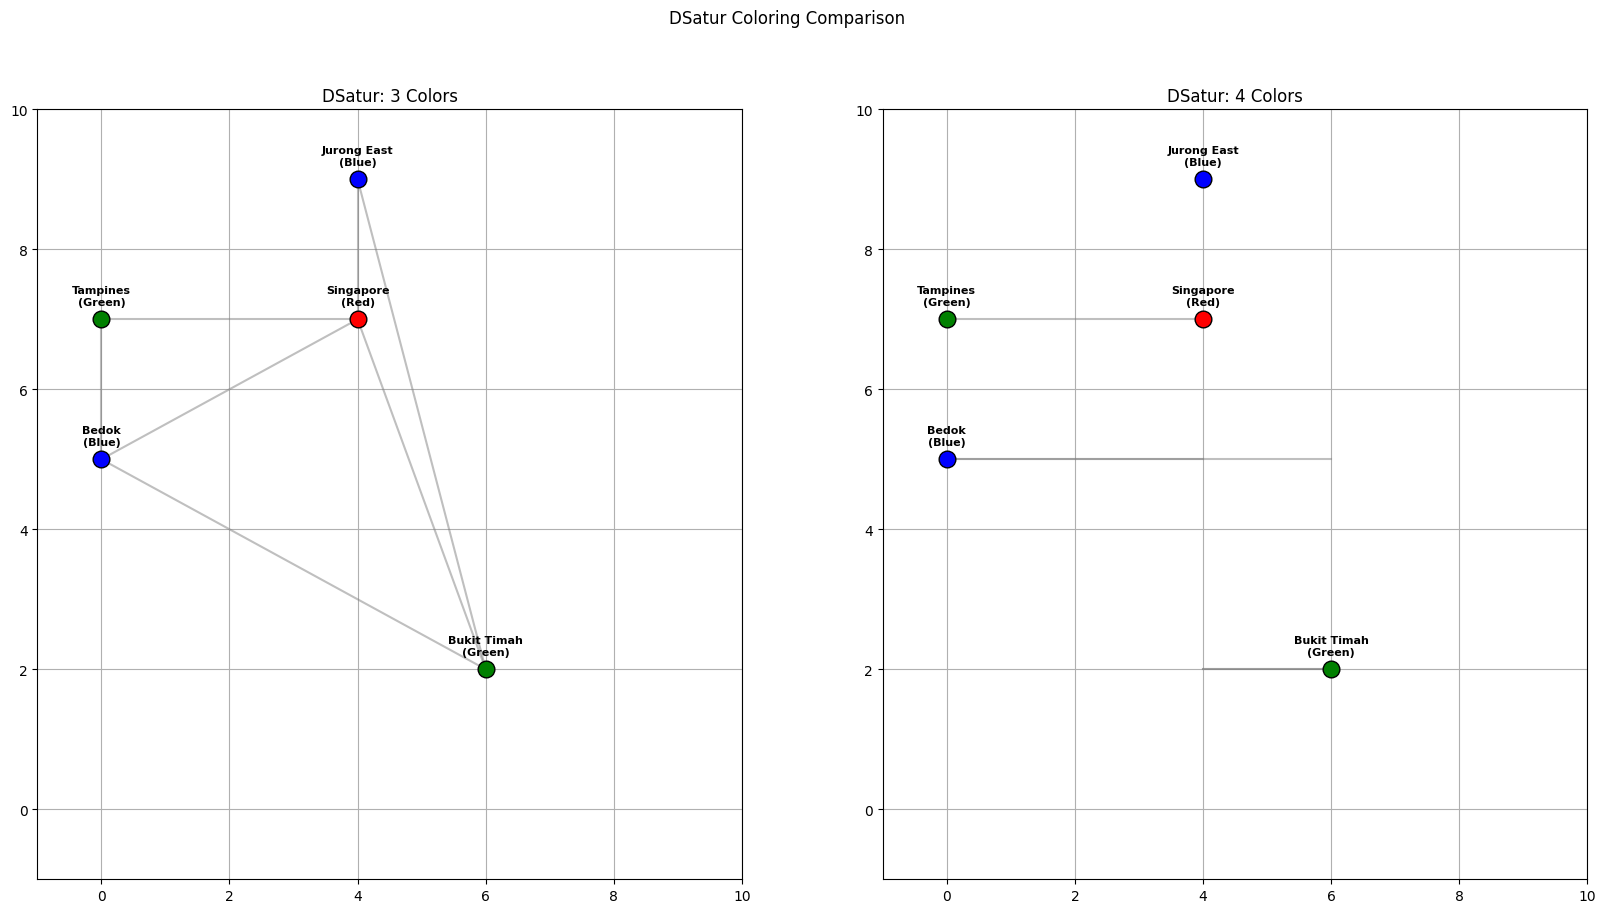

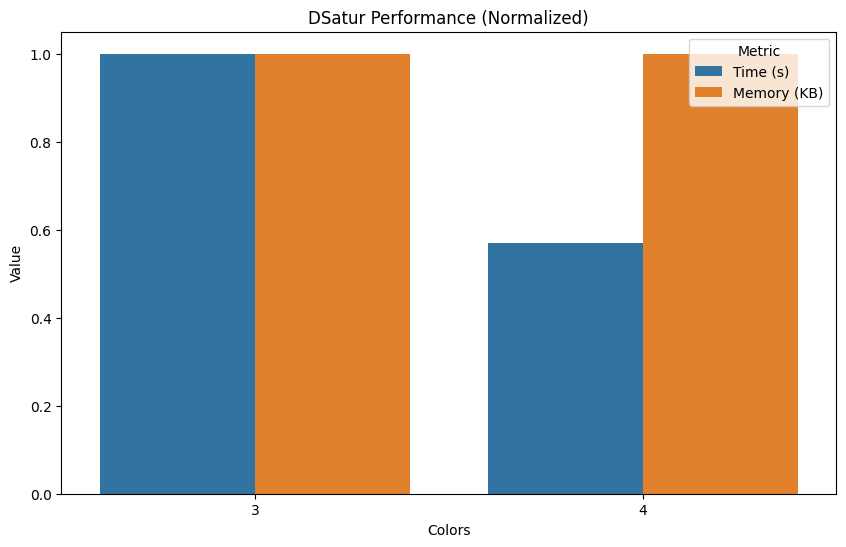

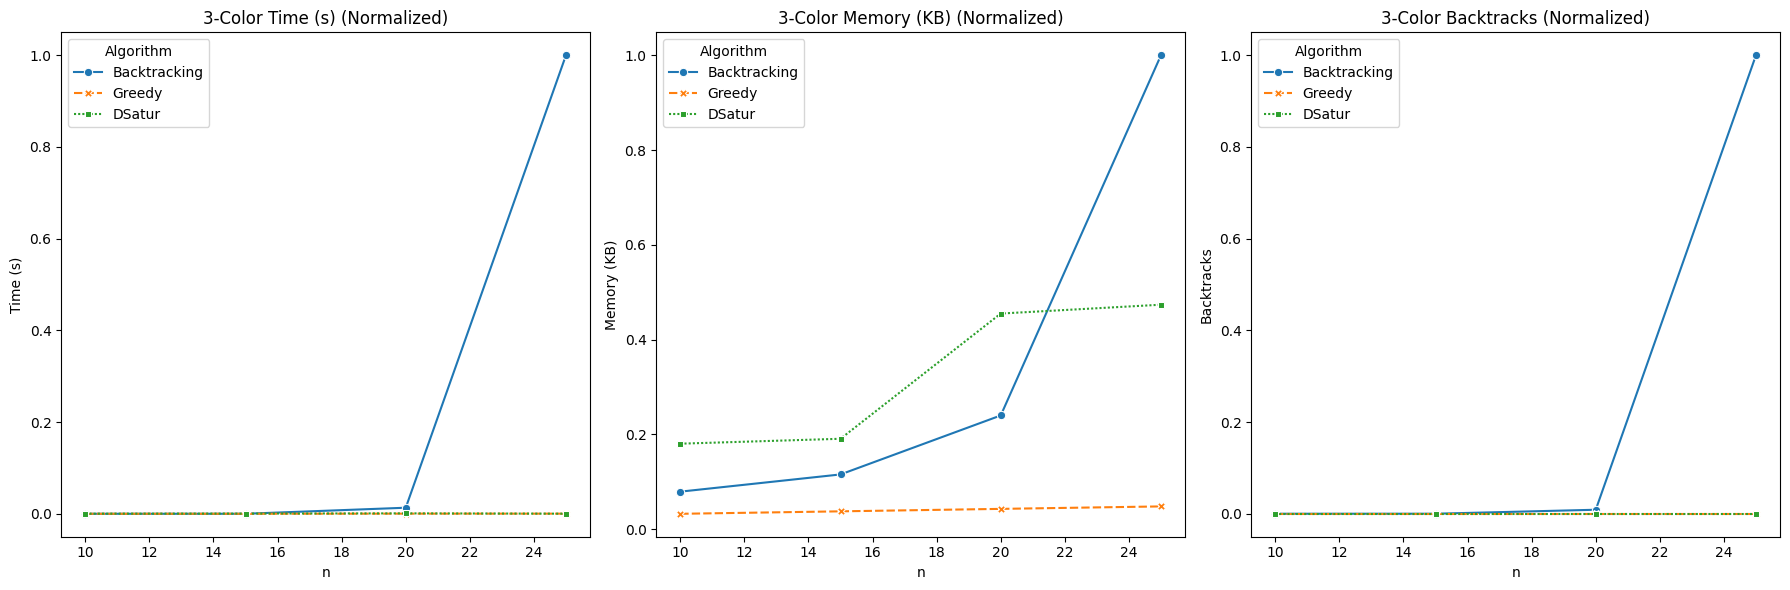

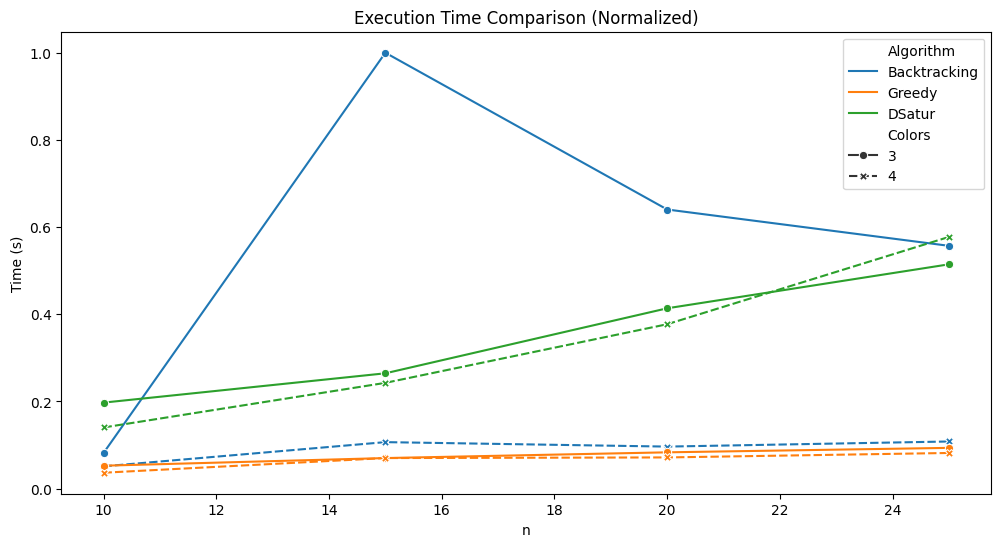

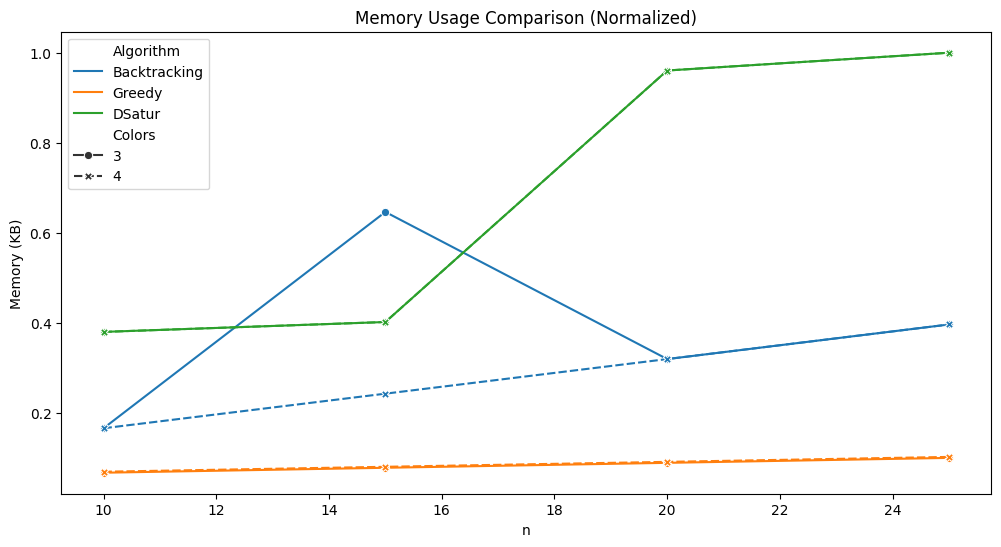

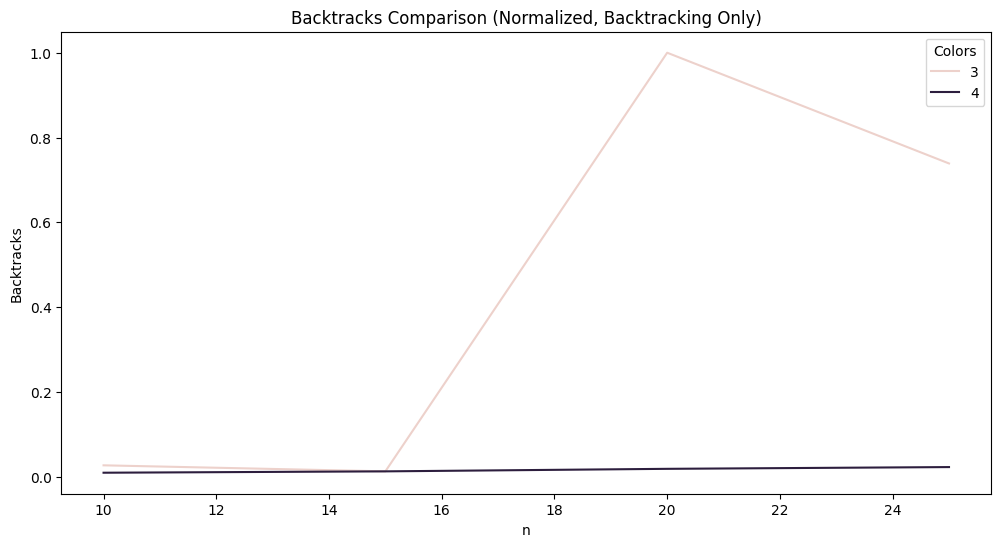

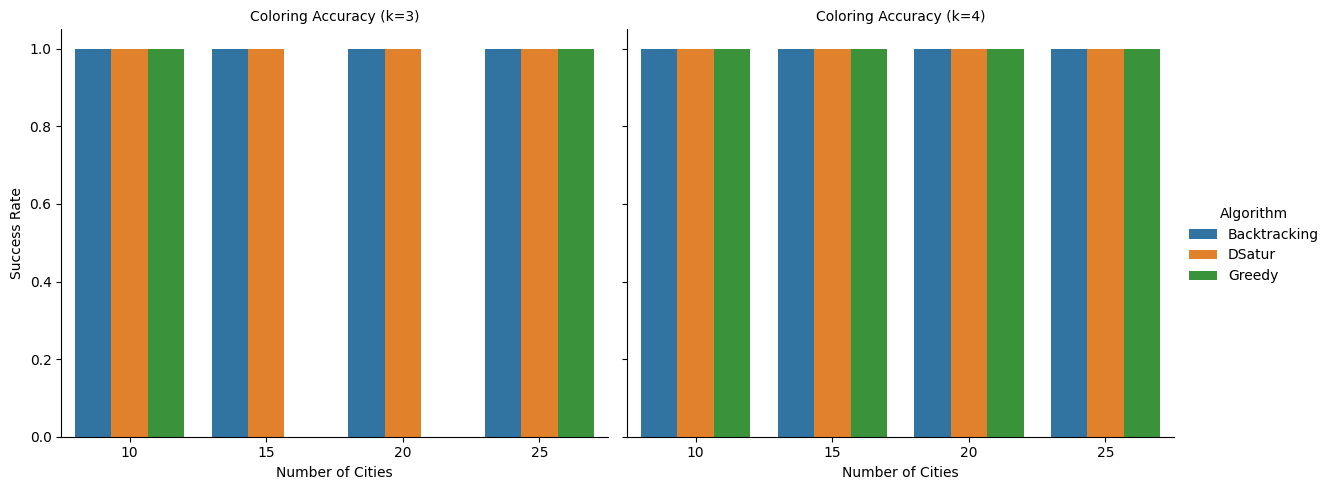

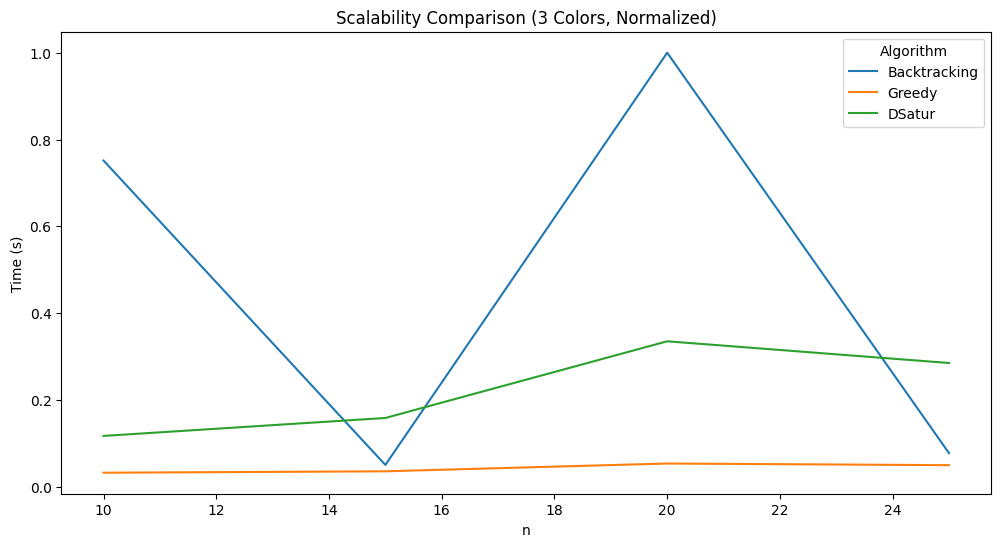

In [44]:
# Main Execution
if __name__ == "__main__":
    print("Singapore Multi-City Lighting Project")
    print("===================================")

    # Get user input
    while True:
        try:
            size = int(input("Enter map dimension (n for n x n grid, 5-20 recommended): "))
            if size < 2:
                print("Map size must be at least 2x2")
                continue
            num_cities = int(input(f"Enter number of cities (2-{min(90, len(singapore_cities))}): "))
            if num_cities < 2:
                print("You need at least 2 cities")
                continue
            if num_cities > len(singapore_cities):
                print(f"Cannot place more than {len(singapore_cities)} cities")
                continue
            if num_cities > size * size:
                print(f"Too many cities for map size. Max allowed is {size * size}")
                continue
            break
        except ValueError:
            print("Please enter valid integers")

    # Initialize graphA
    graphA = CityMap(size, num_cities, singapore_cities)
    graphA.generate()
    graphA.connect_cities()

    # Visualize individual solutions
    for algo, algo_name in [(BacktrackingColoring, 'Backtracking'),
                           (GreedyColoring, 'Greedy'),
                           (DSaturColoring, 'DSatur')]:
        solver = algo(graphA)
        for k in [3, 4]:
            colors = solver.color(k)
            if colors:
                solver.display(colors, k)

    # Run comparisons
    backtracking_color_comparison(graphA)
    backtracking_performance_chart(graphA)
    greedy_color_comparison(graphA)
    greedy_performance_chart(graphA)
    dsatur_color_comparison(graphA)
    dsatur_performance_chart(graphA)

    # Performance comparisons across sizes
    map_sizes = [10, 15, 20, 25]
    num_cities_list = [10, 15, 20, 25]
    compare_algorithms_3color(map_sizes, num_cities_list)
    compare_execution_time(map_sizes, num_cities_list)
    compare_memory_usage(map_sizes, num_cities_list)
    compare_backtracks(map_sizes, num_cities_list)
    compare_coloring_accuracy(map_sizes, num_cities_list)
    compare_scalability(map_sizes, num_cities_list)